# Dataset Statistics for Compound Disease Sentences

This notebook is designed to show statistics on data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel, make_sentence_df

## Load and Merge DataFrames

In [5]:
edge_level_df = (
    pd.read_table("input/compound_treats_disease.tsv.xz")
    .drop(["disease", "sources", "resource", "resource_id"], axis=1)
)
edge_level_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,doid_id,doid_name,drugbank_id,drug_name,hetionet,n_sentences,has_sentence,partition_rank,split
0,DOID:2531,hematologic cancer,DB00001,Lepirudin,0,0,0,0.71127,10
1,DOID:2531,hematologic cancer,DB00002,Cetuximab,0,0,0,0.22452,9


In [6]:
sql='''
select cand_id as candidate_id, doid_id, drugbank_id, sentence_id, text, array_length(words, 1) as sen_length from (
    select cand_id, "Disease_cid" as doid_id, "Compound_cid" as drugbank_id, sentence_id from 
    (
        select compound_disease.id as "cand_id", compound_disease."Disease_id",
        compound_disease."Disease_cid", compound_disease."Compound_cid", candidate.split from compound_disease 
        inner join candidate on compound_disease.id=candidate.id 
    ) 
    as candidate_splits inner join span on candidate_splits."Disease_id"=span.id
) as candidate_sen inner join sentence on candidate_sen.sentence_id=sentence.id
'''
candidate_sentence_df = pd.read_sql(sql, database_str)
candidate_sentence_df.head(2)

,candidate_id,doid_id,drugbank_id,sentence_id,text,sen_length
0,68061,DOID:184,DB00563,533555,Two patients recieving intravenous high dose m...,31
1,76176,DOID:1936,DB01240,446077,Prostacyclin-dependent differences in TXA2 for...,13


In [7]:
total_candidates_df= (
    edge_level_df
    .merge(candidate_sentence_df, on=["doid_id", "drugbank_id"])
)
total_candidates_df.head(2)

,doid_id,doid_name,drugbank_id,drug_name,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
0,DOID:2531,hematologic cancer,DB00007,Leuprolide,0,6,1,0.58699,9,26220260,77006168,Follicular mucinosis and mycosis-fungoides-lik...,17
1,DOID:2531,hematologic cancer,DB00007,Leuprolide,0,6,1,0.58699,9,30771466,87427460,"Leuprolide (100 g/mouse, s.c.) pretreatment si...",26


In [8]:
dev_candidates = (
    session
    .query(CompoundDisease)
    .filter(
        CompoundDisease.id.in_(
            total_candidates_df
            .query("split==10")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
dev_df = make_sentence_df(dev_candidates)
dev_df.head(2)

,candidate_id,compound,disease,drugbank_id,doid_id,sentence
0,66175,epinephrine,hypothyroid,DB00668,DOID:1459,in vivo treatment of ~~[[2 hypothyroid 2]]~~ r...
1,66259,Baclofen,Parkinson's disease,DB00181,DOID:14330,~~[[1 baclofen 1]]~~ in ~~[[2 parkinson 's dis...


In [9]:
test_candidates = (
    session
    .query(CompoundDisease)
    .filter(
        CompoundDisease.id.in_(
            total_candidates_df
            .query("split==11")
            # Black list ethanol, alcohol and alcohold dependence 
            # Samples too many sentences with the above entities
            .query("drugbank_id!='DB00898'&doid_id!='DOID:0050741'")
            .sample(10000, random_state=120)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
test_df = make_sentence_df(test_candidates)
test_df.head(2)

,candidate_id,compound,disease,drugbank_id,doid_id,sentence
0,65906,Amiloride,hypertension,DB00594,DOID:10763,~~[[1 amiloride 1]]~~ in the treatment of prim...
1,65966,spironolactone,hypertension,DB00421,DOID:10763,in 17 patients with low renin ~~[[2 hypertensi...


In [10]:
#write_candidates_to_excel(dev_df, "../data/sentences/sentence_labels_dev.xlsx")
#write_candidates_to_excel(test_df, "../data/sentences/sentence_labels_test.xlsx")

## Distribution of Sentence Length

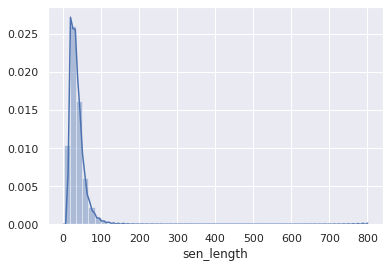

In [11]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [12]:
total_candidates_df["sen_length"].describe().astype(int)

count    2554128
mean          35
std           21
min            3
25%           22
50%           31
75%           43
max          798
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the hundreds range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 36. Possible reason for this abnormality is a parsing error, so lets take a look at this 834 word sentence.

In [13]:
total_candidates_df.query("sen_length==798").iloc[0]["text"]

'RESULTS: Key recommendations and suggestions, listed by category, include: early quantitative resuscitation of the septic patient during the first 6 h after recognition (1C); blood cultures before antibiotic therapy (1C); imaging studies performed promptly to confirm a potential source of infection (UG); administration of broad-spectrum antimicrobials therapy within 1 h of the recognition of septic shock (1B) and severe sepsis without septic shock (1C) as the goal of therapy; reassessment of antimicrobial therapy daily for de-escalation, when appropriate (1B); infection source control with attention to the balance of risks and benefits of the chosen method within 12 h of diagnosis (1C); initial fluid resuscitation with crystalloid (1B) and consideration of the addition of albumin in patients who continue to require substantial amounts of crystalloid to maintain adequate mean arterial pressure (2C) and the avoidance of hetastarch formulations (1B); initial fluid challenge in patients w

The above sentence shows that a long list of drugs that a issue will cover. This isn't helpful in our case, because we want to look at sentences that contain compounds and diseases; therefore, we should remove sentences of this nature by defining a cutoff score of 83 or less words.

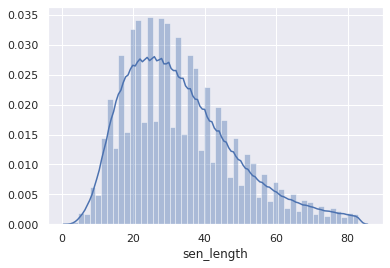

In [14]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [15]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    2482297
mean          33
std           15
min            3
25%           21
50%           31
75%           42
max           83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 1.1 million.

In [16]:
total_candidates_df.to_csv("output/all_ctd_candidates.tsv.xz", sep="\t", compression="xz", index=False)

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 798 words, then the network has 798 steps to parse through. This takes a significant amount of time (~20 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 